In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [2]:
import numpy as np
from bimpcc.dataset import get_dataset
from bimpcc.models.tvregularized import TVRegularized
from bimpcc.models.tvdenoising_model import TVDenoisingMPCC
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [4]:
scale = 16

In [5]:
dataset = get_dataset("cameraman",scale=scale)
true, noisy = dataset.get_training_data()

(np.float64(-0.5), np.float64(15.5), np.float64(15.5), np.float64(-0.5))

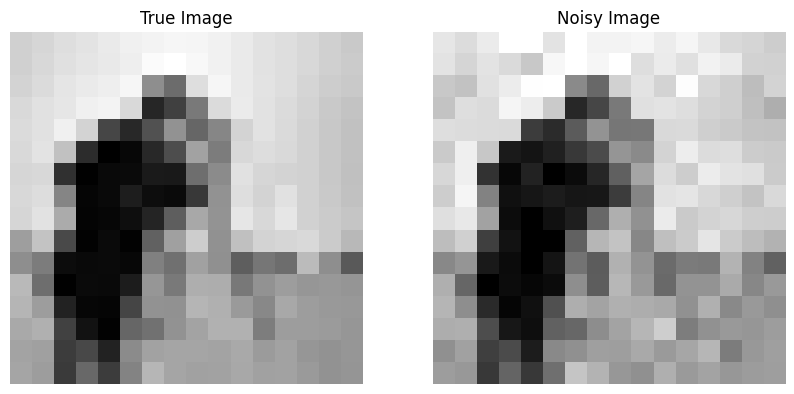

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(noisy,cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

In [7]:
model = TVRegularized(true, noisy, epsilon=1e-3)

In [8]:
res,x_opt,fun_opt = model.solve(max_iter=3000,tol=1e-4,print_level=5)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4036
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      737
                     variables with only lower bounds:      257
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      736
Total number of inequality c

In [9]:
u, q, alpha = model.objective_func.parse_vars(x_opt)

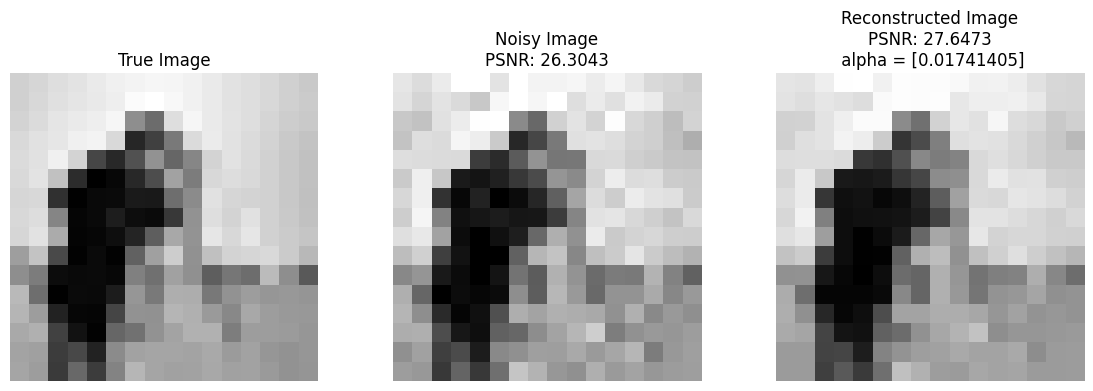

In [10]:
u = u.reshape((scale,scale))
plot_experiment(true,noisy,u,alpha)

In [11]:
m = q.flatten().size
n = m // 2
Ku = model.K @ u.flatten()
V = Ku.reshape(2, -1).T
normKu = np.apply_along_axis(np.linalg.norm, axis=1, arr=V)
Q = q.reshape(2,-1).T
normQ = np.apply_along_axis(np.linalg.norm, axis=1, arr=Q)
r0 = normKu
delta0 = normQ
# theta0 = np.zeros(n)

In [12]:
Kxu = Ku[:n]  # Primeras n componentes
Kyu = Ku[n:]  # Últimas n componentes
qx = q[:n]  # Primeras n componentes
qy = q[n:]  # Últimas n componentes
epsilon = 1e-10  

# Condiciones para calcular theta según los casos dados
theta0 = np.zeros(n)  # Inicializamos theta0

# Caso 1: r_i ≠ 0
mask_r_nonzero = r0 > epsilon
theta0[mask_r_nonzero] = np.arccos(Kxu[mask_r_nonzero] / r0[mask_r_nonzero])
theta0[mask_r_nonzero & (Kyu < 0)] *= -1  # Si Ky^i u < 0, negamos theta0

# Caso 2: r_i = 0 y delta_i ≠ 0
mask_r_zero_delta_nonzero = (r0 <= epsilon) & (delta0 > epsilon)
theta0[mask_r_zero_delta_nonzero] = np.arccos(qx[mask_r_zero_delta_nonzero] / delta0[mask_r_zero_delta_nonzero])
theta0[mask_r_zero_delta_nonzero & (qy < 0)] *= -1  # Si qy^i < 0, negamos theta0

# Caso 3: r_i = 0 y delta_i = 0 (theta0 indefinido)
mask_r_zero_delta_zero = (r0 <= epsilon) & (delta0 <= epsilon)
theta0[mask_r_zero_delta_zero] = 0

In [13]:
x0_mpcc = np.concatenate((u.flatten(),q.flatten(),r0,delta0,theta0,alpha))
print(x0_mpcc)

[ 0.87801868  0.87365001  0.91139987 ...  0.54213705 -0.08090701
  0.01741405]


In [14]:
mpcc_model = TVDenoisingMPCC(true, noisy, x0=x0_mpcc, epsilon=1e-3)

In [15]:
res_mpcc,x_opt_mpcc,fun_opt_mpcc = mpcc_model.solve(max_iter=100,tol=1e-4,print_level=5,verbose=True)

Iter   Termination_status            Objective      MPCC_compl               t

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2003021e-01 9.71e-03 1.17e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

0                 0  0.07120841072862891     3.431783444014788                  1.0

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1208411e-02 4.51e-01 1.12e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

1                 0  0.07124346987218193     3.4011045471642065                 0.5

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1243470e-02 2.33e-01 1.04e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

2                 0  0.07124346987159333     2.6263271382643123                0.25

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1243470e-02 1.09e-01 1.12e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

3                -2  0.0738029992585858      1.6839083495745342               0.125

Restoration phase in the restoration phase failed.

Number of Iterations....: 447

                                   (scaled)                 (unscaled)
Objective...............:   7.3802999258585800e-02    7.3802999258585800e-02
Dual infeasibility......:   7.6142093026796809e-02    7.6142093026796809e-02
Constraint violation....:   8.1016152120305662e-11    8.1016152120305662e-11
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.0000000000000008e-11    5.0000000000000008e-11
Overall NLP error.......:   7.6142093026796809e-02    7.6142093026796809e-02


Number of objective function evaluations             = 903
Number of objective gradient evaluations             = 415
Number of equality constraint evaluations            = 903
Number of inequality constraint evaluations          = 903
Number of equality constraint Jacobian evaluations   = 450
Number of inequality constraint Jacobian evaluations = 450
Number of Lagrangian Hessian

4                 0  0.07154003967465854     1.796059871198102               0.1375

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1540040e-02 6.81e-02 1.18e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

5                 0  0.07605150219984395     1.0535595753036642      0.061875000000000006

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.6051502e-02 3.40e-02 1.16e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

6                 0  0.08802538423403462     0.6688967942328303      0.027843750000000004

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.8025384e-02 1.53e-02 1.21e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

7                -3  0.10778145483150536     0.4286534439607934      0.012529687500000003

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.8025384e-02 1.41e-02 1.21e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

8                 0  0.10513800863223394     0.44822348388987454     0.013782656250000004

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0513801e-01 1.00e-02 1.22e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

9                 0  0.13549938036877726     0.2670497892460237      0.005581975781250002

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3549938e-01 1.00e-02 1.20e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

10                 0  0.16556517030887732     0.16359199799722887     0.0022607001914062507

Complementarity.........:   1.0000000005159364e-11    1.0000000005159364e-11
Overall NLP error.......:   5.9935383699998771e-09    5.9935383699998771e-09


Number of objective function evaluations             = 106
Number of objective gradient evaluations             = 84
Number of equality constraint evaluations            = 106
Number of inequality constraint evaluations          = 106
Number of equality constraint Jacobian evaluations   = 84
Number of inequality constraint Jacobian evaluations = 84
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 1.438

EXIT: Optimal Solution Found.
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
               

11                 0  0.1895204752769979      0.09761274576371737     0.0009155835775195316

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8952048e-01 9.93e-03 1.18e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

12                 0  0.20500382770210357     0.05770171424821765     0.00037081134889541036

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0500383e-01 9.91e-03 1.17e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

13                 0  0.2128970806872488      0.033290843508617655    0.00015017859630264121

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1289708e-01 9.91e-03 1.17e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

14                 0  0.21671729245189583     0.01885321290936404     6.082233150256969e-05

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1671729e-01 9.88e-03 1.16e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

15                 0  0.21852060839466184     0.010403809992759855    2.4633044258540727e-05

Intermediate result:  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the 
convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 0.21852060839466184
       x: [ 8.779e-01  8.736e-01 ... -3.463e-02  1.757e-02]
     nit: 37
    info:     status: 0
                   x: [ 8.779e-01  8.736e-01 ... -3.463e-02  1.757e-02]
                   g: [-9.479e-09 -9.427e-09 ... -2.082e-17  6.700e-17]
             obj_val: 0.21852060839466184
              mult_g: [-1.921e-02 -1.746e-02 ...  3.337e-03  5.181e-04]
            mult_x_L: [ 1.139e-11  1.145e-11 ...  0.000e+00  5.692e-10]
            mult_x_U: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
          status_msg: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence 
tolerances (can be specified by options).'
    nfev: 50
    njev: 39

Intermediate fn: 0.21852060839466184

complementarity: 0.010403809992759855

* (STOPPED) Iteration 17: Solving the NLP problem for t = 1e-05 with complementarity: 0.010403809992759855

In [16]:
u_mpcc, q_mpcc, r_mpcc, delta_mpcc, theta_mpcc, alpha_mpcc = mpcc_model.objective_func.parse_vars(x_opt_mpcc)

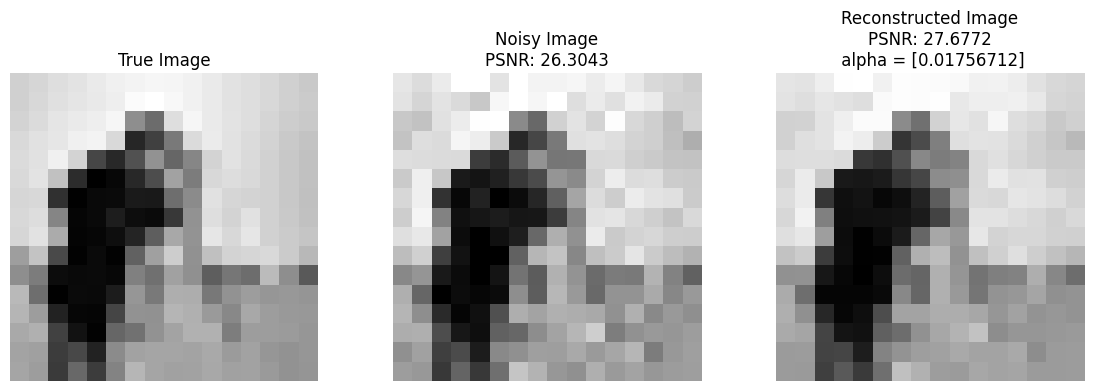

In [17]:
u_mpcc = u_mpcc.reshape((scale,scale))
plot_experiment(true,noisy,u_mpcc,alpha_mpcc)